In [53]:
# Cell 1 — Imports & Config
import os, json, math, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140
sns.set_context("notebook")

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Paths
DATA_PATH  = "data/housing_adequacy_dataset.csv"
CACHE_PATH = "best_params_cache.json"

# Evaluation/baseline options
CUTOFF_DATE = "2018-12-31"   # train ≤ cutoff, test > cutoff
MASE_SEASON = 1              # 1 = last quarter baseline; use 4 for same-quarter last year


In [54]:
# Cell 2 — Build Modeling Frame (lags + selection)
def build_model_frame(df: pd.DataFrame):
    """
    Returns (model_df, feat_cols) with leak-free lags.
    Requires cols: quarter, province, dwelling_starts, pop_change_q, needed_units_q
    """
    df = df.sort_values(["province", "quarter"]).copy()
    df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q").to_timestamp()

    # target
    df["y"] = df["dwelling_starts"]

    # core lags for h=1
    for col in ["dwelling_starts", "pop_change_q", "needed_units_q"]:
        df[f"{col}_lag1"] = df.groupby("province")[col].shift(1)

    # seasonal lag
    df["dwelling_starts_lag4"] = df.groupby("province")["dwelling_starts"].shift(4)

    # optional extras (not in feat_cols by default)
    df["dwelling_starts_lag2"] = df.groupby("province")["dwelling_starts"].shift(2)
    df["dwelling_starts_lag3"] = df.groupby("province")["dwelling_starts"].shift(3)
    df["diff1"] = df["dwelling_starts_lag1"] - df["dwelling_starts_lag2"]

    # quarter dummies (Q1 baseline)
    qdum = pd.get_dummies(df["quarter"].dt.quarter, prefix="q")
    df = pd.concat([df, qdum[[c for c in qdum.columns if c != "q_1"]]], axis=1)

    # final feature set (safe for h=1)
    feat_cols = [
        "dwelling_starts_lag1",
        "dwelling_starts_lag4",
        "pop_change_q_lag1",
        "needed_units_q_lag1",
        # You can re-enable these if desired:
        # "q_2", "q_3", "q_4", "diff1", "dwelling_starts_lag2", "dwelling_starts_lag3"
    ]

    model_df = df.dropna(subset=["y"] + feat_cols).reset_index(drop=True)
    return model_df, feat_cols


In [55]:
# Cell 3 — Splits & Metrics
def chrono_split(df, cutoff=CUTOFF_DATE):
    cutoff = pd.Timestamp(cutoff)
    tr = df[df["quarter"] <= cutoff].copy()
    te = df[df["quarter"] >  cutoff].copy()
    return tr, te

def rolling_split(df, initial=None, step=1, fh=1):
    """
    Expanding-window CV over the full panel (all provinces).
    Yields (train_df, test_df) for the next fh quarters (panel slices).
    Robust to dtype issues in 'quarter'.
    """
    df = df.copy()
    df["quarter"] = pd.to_datetime(df["quarter"], errors="coerce")

    # use a real DatetimeIndex and pandas sorting
    dates = pd.Index(df["quarter"].dropna().unique()).sort_values()

    if len(dates) == 0:
        return  # nothing to yield

    # normalize 'initial'
    if initial is None:
        initial = dates[int(0.6 * len(dates))]
    else:
        initial = pd.Timestamp(initial)

    # use pandas indexer (avoids np.searchsorted type issues)
    start_idx = dates.get_indexer([initial], method="ffill")[0]
    start_idx = max(start_idx, 0)

    for i in range(start_idx, len(dates) - fh, step):
        train_end = dates[i]
        test_slice = dates[i+1 : i+1+fh]
        tr = df[df["quarter"] <= train_end].copy()
        te = df[df["quarter"].isin(test_slice)].copy()
        if not te.empty:
            yield tr, te


def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    eps = 1e-8
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))
    return {"MAE": mae, "RMSE": rmse, "sMAPE": smape}

def _naive_mae_train(y_train: pd.Series, season: int = 1, eps: float = 1e-12) -> float:
    y = y_train.to_numpy()
    if len(y) <= season:
        return np.nan
    denom = np.mean(np.abs(y[season:] - y[:-season]))
    return max(denom, eps)


In [56]:
# Cell 4 — Model factory & param spaces

def make_model(name, **kw):
    """
    Build the estimator first, then apply params via set_params(**kw).
    This lets us pass pipeline-style keys like 'est__alpha' safely.
    """
    if name == "lr":
        model = LinearRegression()
    elif name == "ridge":
        model = Pipeline([("scaler", StandardScaler()), ("est", Ridge())])
    elif name == "lasso":
        model = Pipeline([("scaler", StandardScaler()), ("est", Lasso(max_iter=20000))])
    elif name == "enet":
        model = Pipeline([("scaler", StandardScaler()), ("est", ElasticNet(max_iter=20000))])
    elif name == "rf":
        model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    elif name == "etr":
        model = ExtraTreesRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    elif name == "gbr":
        model = GradientBoostingRegressor(random_state=RANDOM_STATE)
    elif name == "svr":
        model = Pipeline([("scaler", StandardScaler()), ("est", SVR())])
    elif name == "xgb":
        model = XGBRegressor(
            tree_method="hist",
            n_estimators=400,
            learning_rate=0.05,
            random_state=RANDOM_STATE
        )
    else:
        raise ValueError(f"Unknown model: {name}")

    if kw:
        # Works for both plain estimators and Pipelines (e.g., 'est__alpha')
        model.set_params(**kw)
    return model

# PARAM_SPACE = {
#     "lr":   {},  # no hyperparams
#     "ridge": {"est__alpha": np.logspace(-3, 3, 25)},
#     "lasso": {"est__alpha": np.logspace(-4, 1, 30)},
#     "enet":  {"est__alpha": np.logspace(-4, 1, 20), "est__l1_ratio": np.linspace(0.05, 0.95, 10)},
#     "rf":   {"n_estimators": [200, 400, 800],
#              "max_depth": [None, 6, 10, 14],
#              "min_samples_split": [2, 5, 10],
#              "min_samples_leaf": [1, 2, 4],
#              "max_features": ["sqrt", "log2", 0.7, 1.0]},
#     "etr":  {"n_estimators": [400, 800, 1200],
#              "max_depth": [None, 6, 10, 14],
#              "min_samples_split": [2, 5, 10],
#              "min_samples_leaf": [1, 2, 4],
#              "max_features": ["sqrt", "log2", 0.8, 1.0]},
#     "gbr":  {"n_estimators": [300, 600, 1000],
#              "learning_rate": [0.01, 0.03, 0.05, 0.1],
#              "max_depth": [2, 3, 4],
#              "subsample": [0.7, 0.85, 1.0]},
#     "svr":  {"est__C": np.logspace(-2, 3, 12),
#              "est__epsilon": np.logspace(-3, 0, 10),
#              "est__gamma": ["scale", "auto"]},
#     "xgb":  {"max_depth": [3, 4, 6, 8],
#              "min_child_weight": [1, 2, 4, 6],
#              "subsample": [0.7, 0.85, 1.0],
#              "colsample_bytree": [0.6, 0.8, 1.0]},
# }


PARAM_SPACE = {
    "lr":   {},
    "ridge": {"est__alpha": np.logspace(-2, 2, 9)},       # was 25
    "lasso": {"est__alpha": np.logspace(-3, 0.5, 8)},
    "enet":  {"est__alpha": np.logspace(-3, 0.5, 6), "est__l1_ratio": [0.2, 0.5, 0.8]},
    "rf":   {"n_estimators": [200, 400], "max_depth": [None, 8], "min_samples_split": [2, 5],
             "min_samples_leaf": [1, 2], "max_features": ["sqrt", 0.8]},
    "etr":  {"n_estimators": [400, 800], "max_depth": [None, 10], "min_samples_split": [2, 5],
             "min_samples_leaf": [1, 2], "max_features": ["sqrt", 0.8]},
    "gbr":  {"n_estimators": [300, 600], "learning_rate": [0.03, 0.1], "max_depth": [2, 3], "subsample": [0.85, 1.0]},
    "svr":  {"est__C": [0.3, 1, 3, 10], "est__epsilon": [0.01, 0.1, 0.3], "est__gamma": ["scale"]},
    "xgb":  {"max_depth": [3, 6], "min_child_weight": [1, 4], "subsample": [0.8, 1.0], "colsample_bytree": [0.8, 1.0]},
}


In [57]:
# Cell 5 — Tuning (expanding-window) + caching
def sample_param_grid(space: dict, n_iter: int, rng: np.random.RandomState):
    if not space:
        return [dict()]  # e.g., LR
    keys = list(space.keys())
    samples = []
    for _ in range(n_iter):
        d = {}
        for k in keys:
            v = space[k]
            if isinstance(v, (list, tuple, np.ndarray)):
                d[k] = v[rng.randint(0, len(v))]
            else:
                d[k] = v
        samples.append(d)
    return samples

def rolling_score_one_fold(model, tr, te, features, target="dwelling_starts", season=MASE_SEASON):
    Xtr, ytr = tr[features], tr[target]
    Xte, yte = te[features], te[target]
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    denom = _naive_mae_train(ytr, season=season)
    mae = mean_absolute_error(yte, ypred)
    return mae / denom

def tune_model_for_province(df, features, model_name, n_iter=25, fh=1, initial=None,
                            target="dwelling_starts", season=MASE_SEASON, random_state=RANDOM_STATE):
    space = PARAM_SPACE[model_name]
    rng = np.random.RandomState(random_state)
    candidates = sample_param_grid(space, n_iter=n_iter, rng=rng)
    if not candidates:
        candidates = [dict()]

    scores = []
    for params in candidates:
        fold_scores = []
        for tr, te in rolling_split(df, initial=initial, fh=fh):
            m = make_model(model_name, **params)
            try:
                s = rolling_score_one_fold(m, tr, te, features, target=target, season=season)
                if np.isfinite(s):
                    fold_scores.append(s)
            except Exception:
                pass
        score = np.mean(fold_scores) if len(fold_scores) else np.inf
        scores.append((params, score))

    scores.sort(key=lambda x: x[1])
    best_params, best_score = scores[0]
    return best_params, best_score, scores

def tune_all_models_per_province(train_df, features, models_to_run, n_iter=25, fh=1,
                                 initial=None, target="dwelling_starts",
                                 season=MASE_SEASON, random_state=RANDOM_STATE):
    best_params = {}
    best_scores = {}

    provinces = list(train_df["province"].unique())
    total_tasks = len(provinces) * len(models_to_run)
    task = 0

    print(f"🧮 Starting tuning: {len(provinces)} provinces × {len(models_to_run)} models × {n_iter} param trials")
    for prov, gtr in train_df.groupby("province"):
        for name in models_to_run:
            task += 1
            print(f"→ [{task}/{total_tasks}] {prov.upper()} — {name.upper()} ...", end=" ", flush=True)
            bp, bs, _ = tune_model_for_province(
                df=gtr, features=features, model_name=name, n_iter=n_iter, fh=fh,
                initial=initial, target=target, season=season, random_state=random_state
            )
            best_params[(prov, name)] = bp
            best_scores[(prov, name)] = bs
            print(f"best MASE={bs:.3f}")
    print("✅ Tuning done.")
    return best_params, best_scores

def load_or_tune_best_params(train_df, features, models_to_run,
                             cache_path=CACHE_PATH, n_iter=20, fh=1, initial=None):
    if os.path.exists(cache_path):
        print(f"🔁 Loading cached best parameters from {cache_path}")
        with open(cache_path, "r") as f:
            best_params = json.load(f)
        # convert "prov|model" keys back to tuple
        best_params = {tuple(k.split("|")): v for k, v in best_params.items()}
        return best_params
    else:
        print("⏳ Running tuning from scratch...")
        best_params, best_scores = tune_all_models_per_province(
            train_df=train_df,
            features=features,
            models_to_run=models_to_run,
            n_iter=n_iter,
            fh=fh,
            initial=initial,
            target="dwelling_starts",
            season=MASE_SEASON,
            random_state=RANDOM_STATE
        )
        # save to JSON
        best_params_str = {"|".join(k): v for k, v in best_params.items()}
        with open(cache_path, "w") as f:
            json.dump(best_params_str, f, indent=2)
        print(f"✅ Saved tuned best parameters to {cache_path}")
        return best_params


In [58]:
# Cell 6 — Final fit (TRAIN) with tuned params, predict on TEST
def fit_predict_holdout_per_province(train_df, test_df, features, models_to_run, best_params,
                                     target="dwelling_starts"):
    rows = []
    for prov, gtr in train_df.groupby("province"):
        gte = test_df[test_df["province"] == prov]
        if gte.empty:
            continue
        for name in models_to_run:
            params = best_params.get((prov, name), {})
            m = make_model(name, **params)
            Xtr, ytr = gtr[features], gtr[target]
            Xte, yte = gte[features], gte[target]
            m.fit(Xtr, ytr)
            ypred = m.predict(Xte)

            res = metrics(yte, ypred)
            denom = _naive_mae_train(ytr, season=MASE_SEASON)
            res["MASE"] = res["MAE"] / denom

            for q, yt, yp in zip(gte["quarter"].values, yte.values, ypred):
                rows.append({
                    "province": prov, "model": name,
                    "quarter": pd.to_datetime(q), "y_true": yt, "y_pred": yp,
                    **res
                })
    return pd.DataFrame(rows)

def summarize_metrics_table(preds_df: pd.DataFrame):
    g_model = (preds_df.groupby("model")[["MAE","RMSE","sMAPE","MASE"]]
               .mean().round(2).sort_values("MASE"))
    display(g_model)
    g_pm = (preds_df.groupby(["province","model"])[["MAE","RMSE","sMAPE","MASE"]]
            .mean().round(2))
    return g_model, g_pm


In [ ]:
# Cell 7 — Visualizations
def plot_holdout_overlay(preds_df, models_to_run, suptitle="True vs Predicted (Holdout) — Overlaid Models (Tuned)"):
    provs = sorted(preds_df["province"].unique())
    cols = 4
    rows = math.ceil(len(provs) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.6*rows), sharex=False, sharey=False)
    axes = axes.ravel()

    for i, prov in enumerate(provs):
        ax = axes[i]
        g = preds_df[preds_df["province"] == prov].copy()
        truth = g.drop_duplicates("quarter")[["quarter","y_true"]].sort_values("quarter")
        ax.plot(truth["quarter"], truth["y_true"], color="black", linewidth=2.0, label="True")

        for name in models_to_run:
            gm = g[g["model"] == name].sort_values("quarter")
            if gm.empty:
                continue
            ax.plot(gm["quarter"], gm["y_pred"], "--", linewidth=1.5, label=name.upper())

        ax.set_title(prov.upper(), fontsize=10)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(i+1, rows*cols):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=min(2+len(models_to_run), 6), frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle(suptitle, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

def rolling_evolution_plot(df_all, features, best_params, model_name, fh=1, initial=None, target="dwelling_starts"):
    rows = []
    for tr, te in rolling_split(df_all, initial=initial, fh=fh):
        cutoff = tr["quarter"].max()
        for prov, gtr in tr.groupby("province"):
            gte = te[te["province"] == prov]
            if gte.empty:
                continue
            params = best_params.get((prov, model_name), {})
            m = make_model(model_name, **params)
            Xtr, ytr = gtr[features], gtr[target]
            Xte, yte = gte[features], gte[target]
            m.fit(Xtr, ytr)
            rows.append(pd.DataFrame({
                "cutoff": cutoff,
                "province": prov,
                "quarter": gte["quarter"].values,
                "y_true": yte.values,
                "y_pred": m.predict(Xte)
            }))

    df = pd.concat(rows, ignore_index=True)
    df["quarter"] = pd.to_datetime(df["quarter"])
    df["cutoff"]  = pd.to_datetime(df["cutoff"])
    df = df.sort_values(["province","cutoff","quarter"])

    cuts = sorted(df["cutoff"].unique())
    cut_rank = {c:i for i,c in enumerate(cuts)}
    df["cut_rank"] = df["cutoff"].map(cut_rank)

    provs = sorted(df["province"].unique())
    cols = 4
    rows = math.ceil(len(provs)/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.6*rows), sharex=False, sharey=False)
    axes = axes.ravel()

    for i, prov in enumerate(provs):
        ax = axes[i]
        g = df[df["province"] == prov]
        truth = g.drop_duplicates("quarter")[["quarter","y_true"]].sort_values("quarter")
        ax.plot(truth["quarter"], truth["y_true"], color="black", linewidth=1.8, label="True")

        for c, gc in g.groupby("cutoff"):
            r = cut_rank[c]
            alpha = 0.25 + 0.6 * (r / (len(cuts) - 1 if len(cuts) > 1 else 1))
            ax.plot(gc["quarter"], gc["y_pred"], "--", color="tab:orange", alpha=alpha, linewidth=1.2)

        latest = g[g["cutoff"] == cuts[-1]].sort_values("quarter")
        if not latest.empty:
            ax.plot(latest["quarter"], latest["y_pred"], "--", color="tab:orange", linewidth=1.8, label="Latest forecast")

        ax.set_title(prov.upper(), fontsize=10)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(i+1, rows*cols):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles[:2], labels[:2], loc="lower center", ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle(f"Rolling forecast evolution — {model_name.upper()} (tuned)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()
    
# New: Rolling overlay (multi-model, like holdout overlay)
def rolling_evolution_overlay(df_all, features, best_params, models_to_plot,
                              fh=1, initial=None, target="dwelling_starts",
                              show_history=False, step=1, last_k_cutoffs=None,
                              return_df=False):
    # normalize model names to lower-case to match best_params keys
    models_to_plot = [m.lower() for m in models_to_plot]

    rows = []
    # collect folds (optionally keep only latest K)
    folds = list(rolling_split(df_all, initial=initial, fh=fh, step=step))
    if last_k_cutoffs is not None and len(folds) > last_k_cutoffs:
        folds = folds[-last_k_cutoffs:]

    for tr, te in folds:
        cutoff = pd.to_datetime(tr["quarter"].max())
        for prov, gtr in tr.groupby("province"):
            gte = te[te["province"] == prov]
            if gte.empty:
                continue

            # guard against lag NaNs
            gtr_ = gtr.dropna(subset=features + [target])
            gte_ = gte.dropna(subset=features + [target])
            if gtr_.empty or gte_.empty:
                continue

            Xtr, ytr = gtr_[features], gtr_[target]
            Xte, yte = gte_[features], gte_[target]

            for name in models_to_plot:
                params = best_params.get((prov, name), {})  # OK if {}
                try:
                    m = make_model(name, **params)
                    m.fit(Xtr, ytr)
                    yhat = m.predict(Xte)
                    if not np.isfinite(yhat).any():
                        continue
                    rows.append(pd.DataFrame({
                        "cutoff": cutoff,
                        "province": prov,
                        "model": name,
                        "quarter": pd.to_datetime(gte_["quarter"].values),
                        "y_true": yte.values,
                        "y_pred": yhat,
                    }))
                except Exception:
                    # skip this (prov, model, fold)
                    continue

    if not rows:
        print("No rolling predictions generated — likely all test folds empty after dropna.")

    df = pd.concat(rows, ignore_index=True)
    df["quarter"] = pd.to_datetime(df["quarter"])
    df["cutoff"]  = pd.to_datetime(df["cutoff"])
    df = df.sort_values(["province","model","cutoff","quarter"])

    # debug table: finite preds count
    chk = (df.assign(ok=np.isfinite(df["y_pred"]))
             .groupby(["province","model"])["ok"].sum().unstack(fill_value=0).sort_index())
    print("\n# finite predictions per province×model")
    print(chk)

    cuts = sorted(df["cutoff"].unique())
    cut_rank = {c:i for i,c in enumerate(cuts)}
    df["cut_rank"] = df["cutoff"].map(cut_rank)

    provs = sorted(df["province"].unique())
    cols = 4
    rows_n = math.ceil(len(provs)/cols)
    fig, axes = plt.subplots(rows_n, cols, figsize=(4*cols, 2.6*rows_n), sharex=False, sharey=False)
    axes = axes.ravel()

    # stable color per model
    palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', None) or ["C0","C1","C2","C3","C4","C5"]
    model_colors = {m: palette[i % len(palette)] for i, m in enumerate(models_to_plot)}

    for i, prov in enumerate(provs):
        ax = axes[i]
        g = df[df["province"] == prov]

        # true series (always)
        truth = (g.drop_duplicates("quarter")[["quarter","y_true"]]
                   .sort_values("quarter"))
        ax.plot(truth["quarter"], truth["y_true"], color="black", linewidth=2.0, label="True")

        for m in models_to_plot:
            gm = g[g["model"] == m]
            if gm.empty:
                continue
            c = model_colors[m]

            if show_history:
                for cu, gc in gm.groupby("cutoff"):
                    if not np.isfinite(gc["y_pred"]).any(): 
                        continue
                    r = cut_rank[cu]
                    alpha = 0.25 + 0.60 * (r / (len(cuts)-1 if len(cuts) > 1 else 1))
                    ax.plot(gc["quarter"], gc["y_pred"], "--", color=c, alpha=alpha, linewidth=1.1)

            # latest only (legend handle)
            if gm["cutoff"].empty:
                continue
            latest_cut = gm["cutoff"].max()
            gl = gm[gm["cutoff"] == latest_cut].sort_values("quarter")
            gl = gl[np.isfinite(gl["y_pred"])]
            if not gl.empty:
                ax.plot(gl["quarter"], gl["y_pred"], "--", color=c, linewidth=1.8, label=m.upper())

        ax.set_title(prov.upper(), fontsize=10)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(i+1, rows_n*cols):
        fig.delaxes(axes[j])

    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=min(2+len(models_to_plot), 6),
               frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle("Rolling forecast evolution — overlay by model", y=1.02, fontsize=12)
    # plt.tight_layout()
    # plt.show()
    if return_df:
        return df




In [76]:
# Cell 8 — Run: load, prep, tune (or load cache), evaluate, visualize

# 1) Load and build modeling frame
raw = pd.read_csv(DATA_PATH)
model_df, feat_cols = build_model_frame(raw)

model_df["quarter"] = pd.to_datetime(model_df["quarter"], errors="coerce")
bad = model_df["quarter"].map(type).value_counts()
print(bad)

# Ensure datetime
if model_df["quarter"].dtype == "O":
    model_df["quarter"] = pd.PeriodIndex(model_df["quarter"], freq="Q").to_timestamp()

# 2) Choose models (trim if runtime is long)
#MODELS = ["lr", "ridge", "lasso", "enet", "rf", "etr", "gbr", "svr", "xgb"]
MODELS = ["lr", "rf", "ridge", "xgb", "etr"]

# 3) Holdout split
train, test = chrono_split(model_df, cutoff=CUTOFF_DATE)
print(f"Train range: {train['quarter'].min().date()} → {train['quarter'].max().date()} | "
      f"Test range: {test['quarter'].min().date()} → {test['quarter'].max().date()}")

# 4) Tune or load cached best params (expanding-window CV on TRAIN)
best_params = load_or_tune_best_params(
    train_df=train,
    features=feat_cols,
    models_to_run=MODELS,
    cache_path=CACHE_PATH,
    n_iter=5,   # ↑ to 40–80 for deeper search
    fh=1,
    initial=None
)

# 5) Final fit (TRAIN) + prediction (TEST) for all models/provinces
preds_holdout = fit_predict_holdout_per_province(
    train_df=train, test_df=test, features=feat_cols,
    models_to_run=MODELS, best_params=best_params, target="dwelling_starts"
)

# 6) Summary tables
print("\n=== Holdout averages across provinces (tuned) ===")
g_model, g_pm = summarize_metrics_table(preds_holdout)


quarter
<class 'pandas._libs.tslibs.timestamps.Timestamp'>    1529
Name: count, dtype: int64
Train range: 1991-01-01 → 2018-10-01 | Test range: 2019-01-01 → 2025-07-01
🔁 Loading cached best parameters from best_params_cache.json

=== Holdout averages across provinces (tuned) ===


,MAE,RMSE,sMAPE,MASE
model,,,,
lr,1269.97,1618.60,22.32,1.68
ridge,1262.02,1624.13,22.60,1.69
rf,1744.92,2103.07,26.76,2.05
etr,1728.85,2079.51,26.73,2.06
xgb,1771.81,2144.87,28.26,2.14


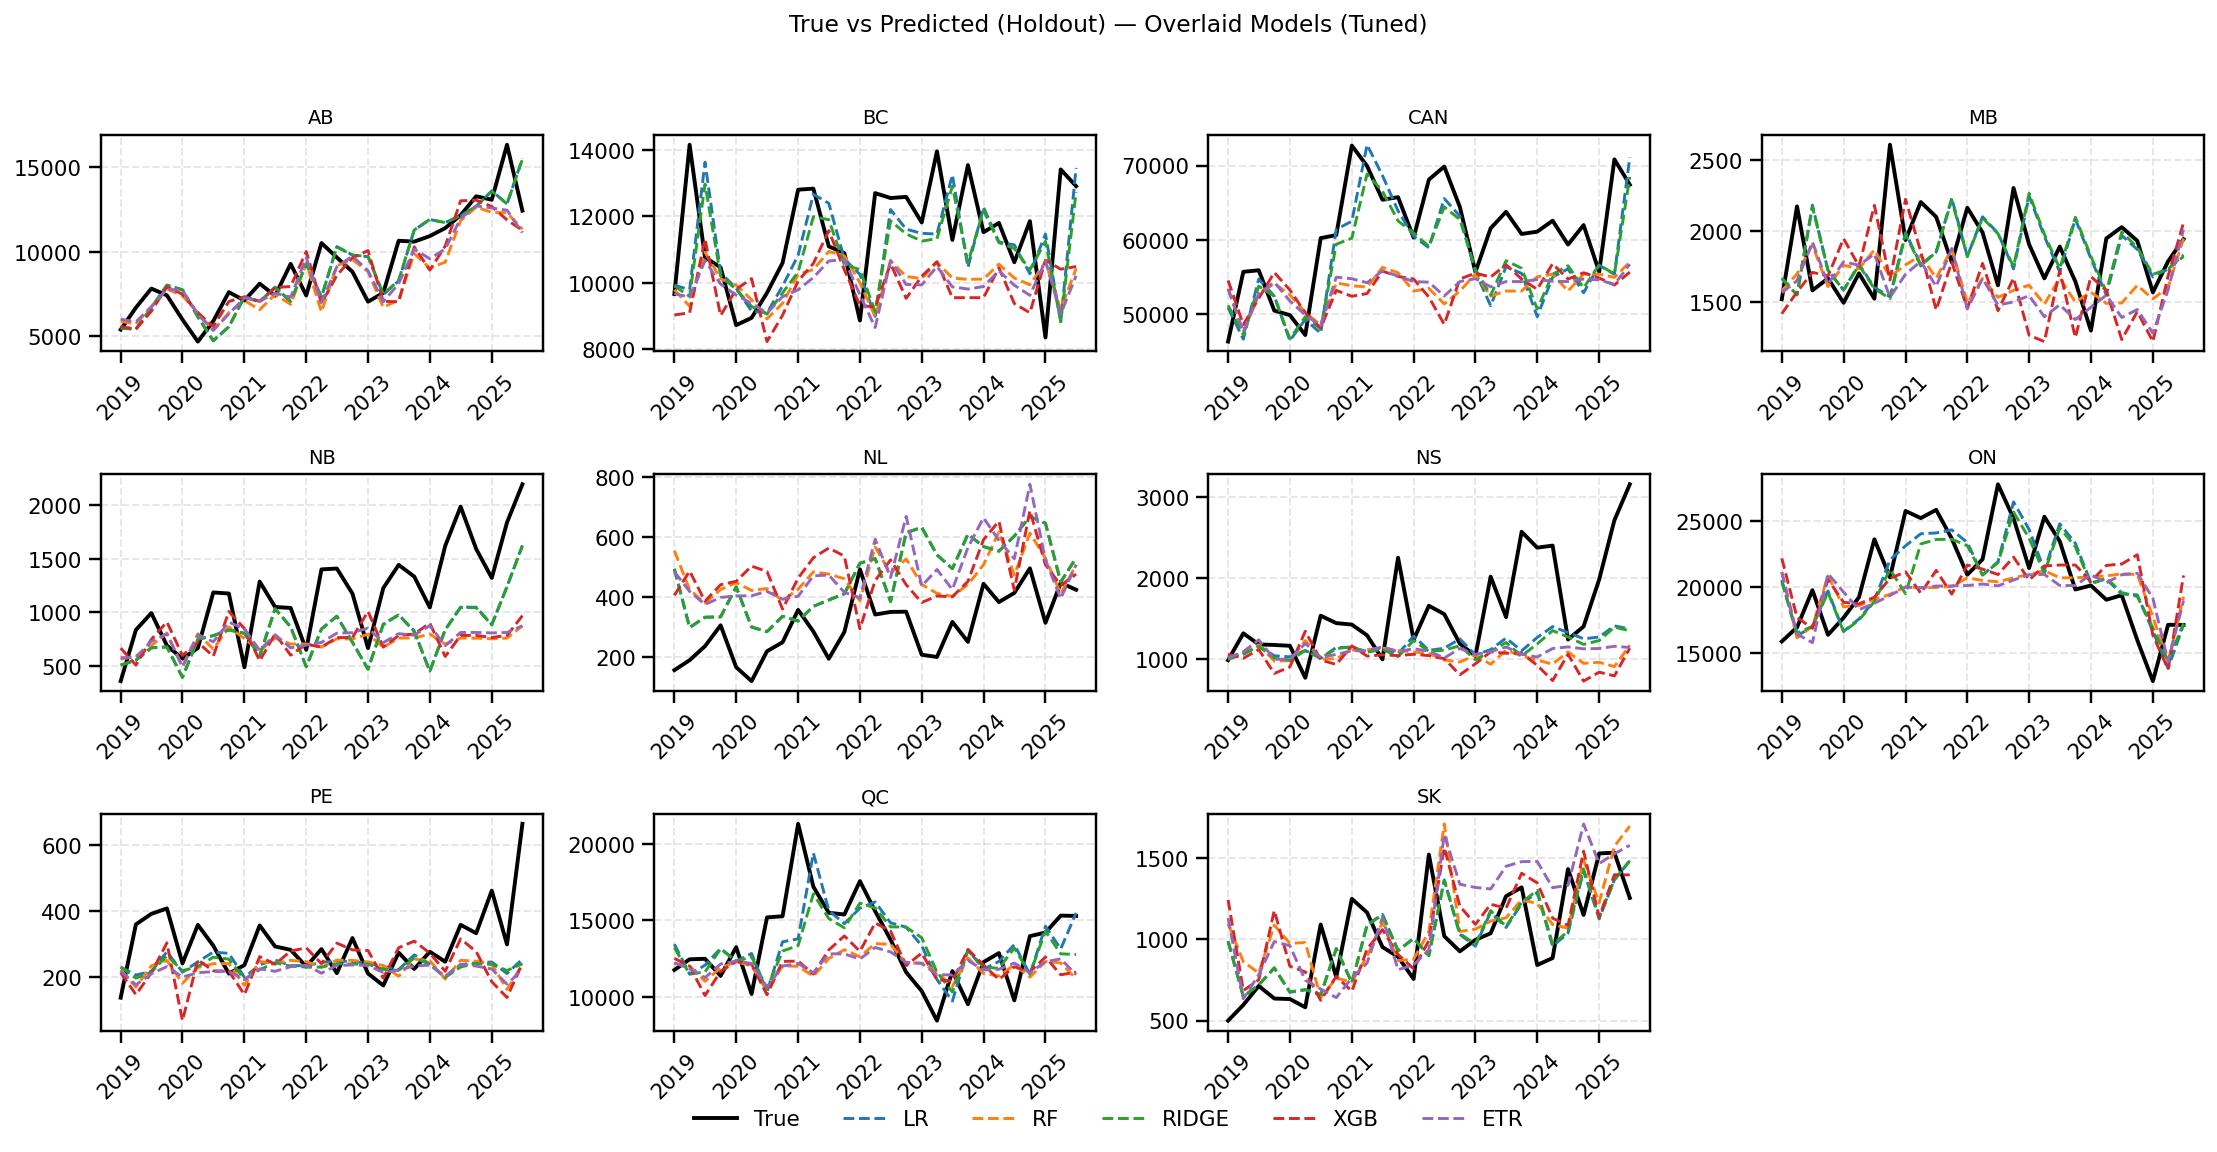

In [77]:

# 7) Train–Test overlay (multiple models per province)
plot_holdout_overlay(preds_holdout, MODELS)



# finite predictions per province×model
model     etr  lr  rf  ridge  xgb
province                         
ab         32  32  32     32   32
bc         32  32  32     32   32
can        32  32  32     32   32
mb         32  32  32     32   32
nb         32  32  32     32   32
nl         32  32  32     32   32
ns         32  32  32     32   32
on         32  32  32     32   32
pe         32  32  32     32   32
qc         32  32  32     32   32
sk         32  32  32     32   32


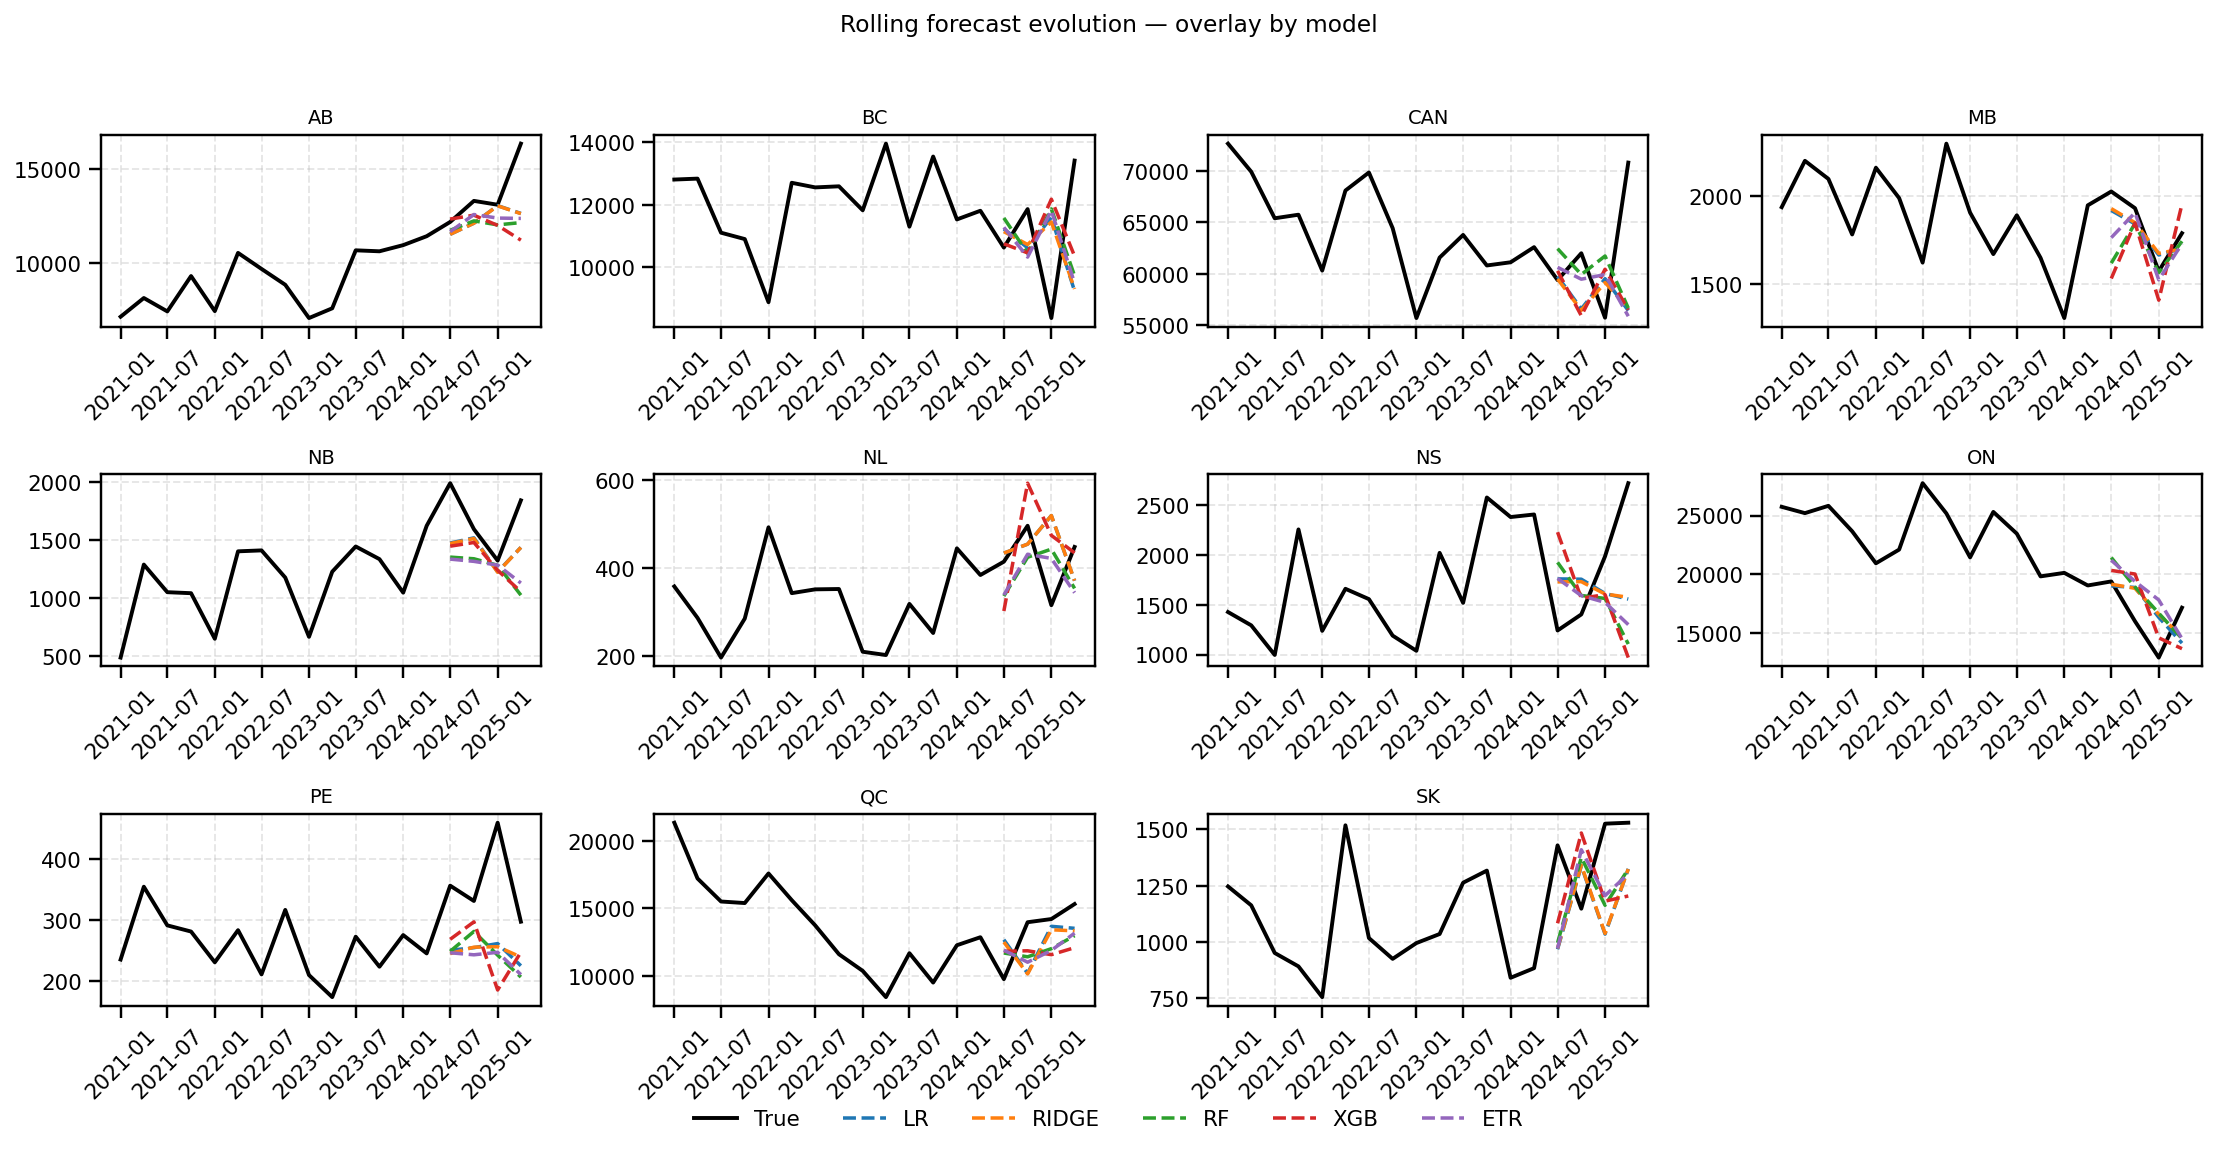

In [100]:

# 8) Rolling evolution plots for a few models (tuned)
# for name in ["lr", "rf", "ridge", "xgb", "etr"]:
#     rolling_evolution_plot(model_df, feat_cols, best_params, model_name=name, fh=1, initial=None, target="dwelling_starts")

preds_roll = rolling_evolution_overlay(
    df_all=model_df,
    features=feat_cols,
    best_params=best_params,
    models_to_plot=["lr","ridge","rf","xgb","etr"],
    fh=4,                   # ← predict next 4 quarters per fold
    initial="2012-12-31",
    step=2,
    last_k_cutoffs=8,
    show_history=False,
    return_df=True,
)


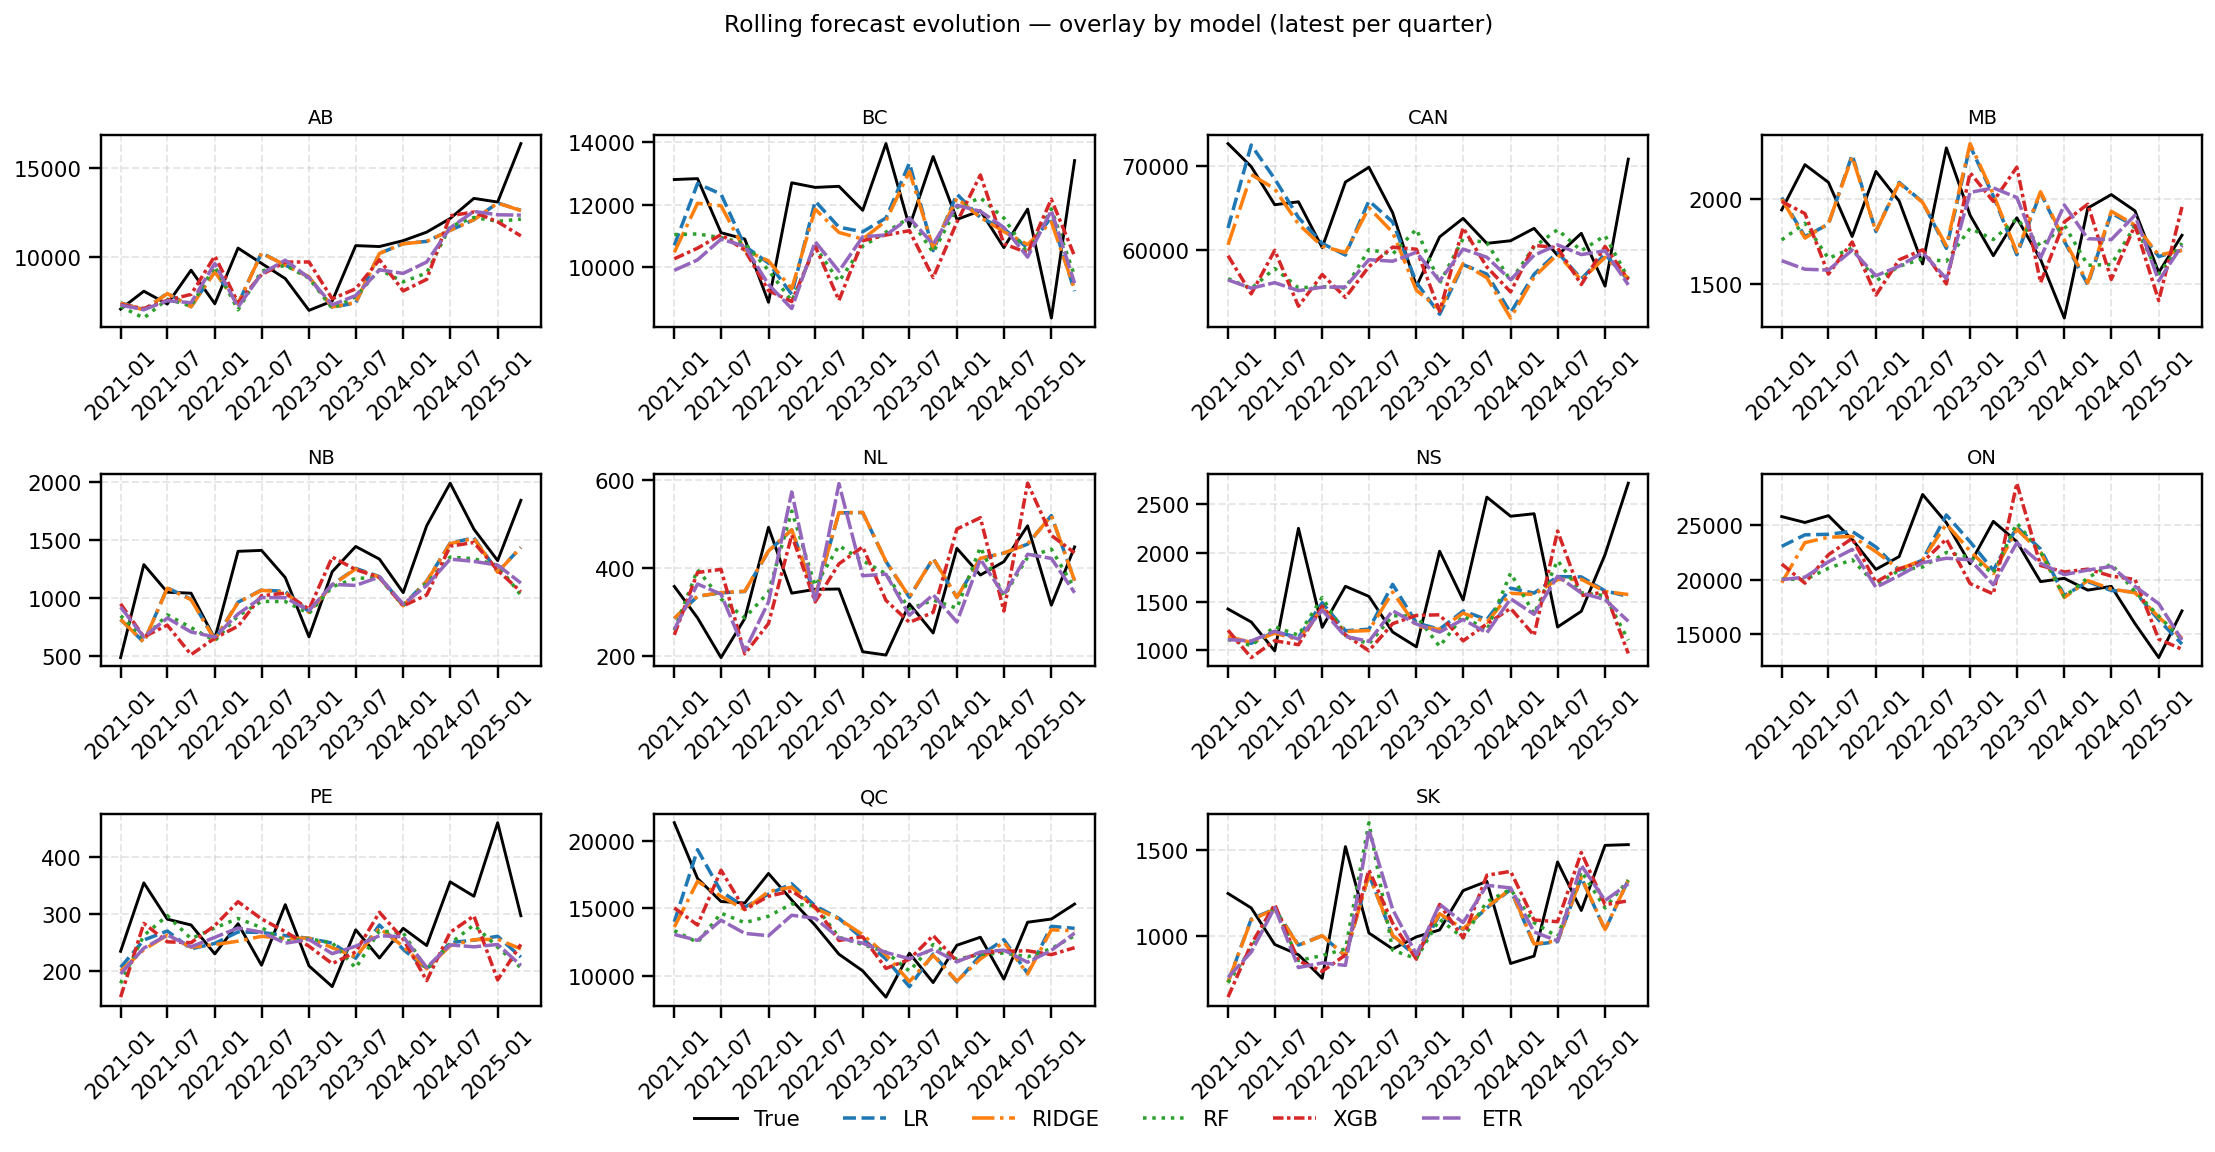

In [101]:
def latest_per_quarter(df_preds):
    # keep the last (latest cutoff) prediction for each province/model/quarter
    d = (df_preds.sort_values(["province","model","quarter","cutoff"])
                 .drop_duplicates(["province","model","quarter"], keep="last"))
    return d.sort_values(["province","model","quarter"])

d_latest = latest_per_quarter(preds_roll)

# Plot as continuous lines (no 'latest cutoff' filter now)
def rolling_overlay_lines(df_preds, models_to_plot):
    models_to_plot = [m.lower() for m in models_to_plot]
    df = df_preds.copy()
    df["model"] = df["model"].str.lower()

    provs = sorted(df["province"].unique())
    cols = 4
    rows_n = math.ceil(len(provs)/cols)
    fig, axes = plt.subplots(rows_n, cols, figsize=(4*cols, 2.6*rows_n), sharex=False, sharey=False)
    axes = axes.ravel()

    palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', ["C0","C1","C2","C3","C4","C5"])
    model_colors = {m: palette[i % len(palette)] for i, m in enumerate(models_to_plot)}
    model_styles = {m: s for m, s in zip(models_to_plot, ["--","-.",":",(0,(3,1,1,1)),(0,(5,1))])}

    for i, prov in enumerate(provs):
        ax = axes[i]
        g = df[df["province"] == prov]

        # truth
        truth = g.drop_duplicates("quarter")[["quarter","y_true"]].sort_values("quarter")
        ax.plot(truth["quarter"], truth["y_true"], color="black", lw=1.5, alpha=1, label="True")

        # one line per model over all quarters
        for m in models_to_plot:
            gl = g[g["model"] == m].sort_values("quarter")
            if gl.empty: 
                continue
            ax.plot(gl["quarter"], gl["y_pred"],
                    linestyle=model_styles[m], color=model_colors[m],
                    marker="", markersize=3, lw=1.8, label=m.upper())

        ax.set_title(prov.upper(), fontsize=10)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid(True, ls="--", alpha=.3)

    for j in range(i+1, rows_n*cols):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center",
               ncol=min(2+len(models_to_plot), 6), frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle("Rolling forecast evolution — overlay by model (latest per quarter)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

rolling_overlay_lines(d_latest, ["lr","ridge","rf","xgb","etr"])


In [102]:
preds_roll.head(20)

,cutoff,province,model,quarter,y_true,y_pred,cut_rank
16,2020-10-01,ab,etr,2021-01-01,7120.583333,7343.583125,0
17,2020-10-01,ab,etr,2021-04-01,8118.166667,7089.863750,0
18,2020-10-01,ab,etr,2021-07-01,7404.166667,7632.706458,0
19,2020-10-01,ab,etr,2021-10-01,9287.833333,7440.028542,0
236,2021-04-01,ab,etr,2021-07-01,7404.166667,7584.981875,1
237,2021-04-01,ab,etr,2021-10-01,9287.833333,7477.691042,1
238,2021-04-01,ab,etr,2022-01-01,7420.750000,9580.573125,1
239,2021-04-01,ab,etr,2022-04-01,10521.416667,7112.498542,1
456,2021-10-01,ab,etr,2022-01-01,7420.750000,9661.334375,2
457,2021-10-01,ab,etr,2022-04-01,10521.416667,7235.575208,2
